# Data Understanding

In [1]:
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("corrplot")) install.packages("corrplot")
if (!require("repr")) install.packages("repr")

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: corrplot

corrplot 0.92 loaded

Loading required package: repr



In [2]:
data <- read.csv("../data/train.csv")

In [3]:
head(data)

,loan_id,loan_date,amount,payments,status,frequency,trans_count,credit_ratio,withdrawal_ratio,smallest_transaction,⋯,urban_ratio,average_salary,entrepreneur_rate,unemployment_rate_avg,crimes_rate_per_thousand,unemployment_growing,crimes_growing,can_afford_loan,can_pay_until,acc_age_when_loan
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>
1,5314,1993-07-05,96396,8033,0,2,4,1.0000000,0.0000000,1100.0,⋯,81.8,9650,100,5.215,0.0550035860,1,0,1,2.502179,105
2,5316,1993-07-11,165960,4610,1,1,37,0.4594595,0.5405405,2.9,⋯,73.5,8369,117,2.945,0.0261292355,1,0,1,11.325141,148
3,6863,1993-07-28,127080,2118,1,1,24,0.6250000,0.3750000,48.6,⋯,53.5,8390,132,3.725,0.0478072821,1,1,1,9.571671,170
4,5325,1993-08-03,105804,2939,1,1,25,0.5200000,0.4800000,-14.6,⋯,58.0,8754,137,5.985,0.0554834523,1,1,1,11.668152,185
5,7240,1993-09-06,274740,4579,1,2,27,0.4814815,0.5185185,-30.0,⋯,100.0,12541,167,0.505,0.0004191035,1,1,1,8.985128,204
6,6687,1993-09-13,87840,3660,1,1,17,0.8235294,0.1764706,51.3,⋯,41.3,8598,123,4.400,0.0816008605,1,1,1,11.980273,124


We can start by doing some simple plots in order to better understand the data that we will be dealing with.

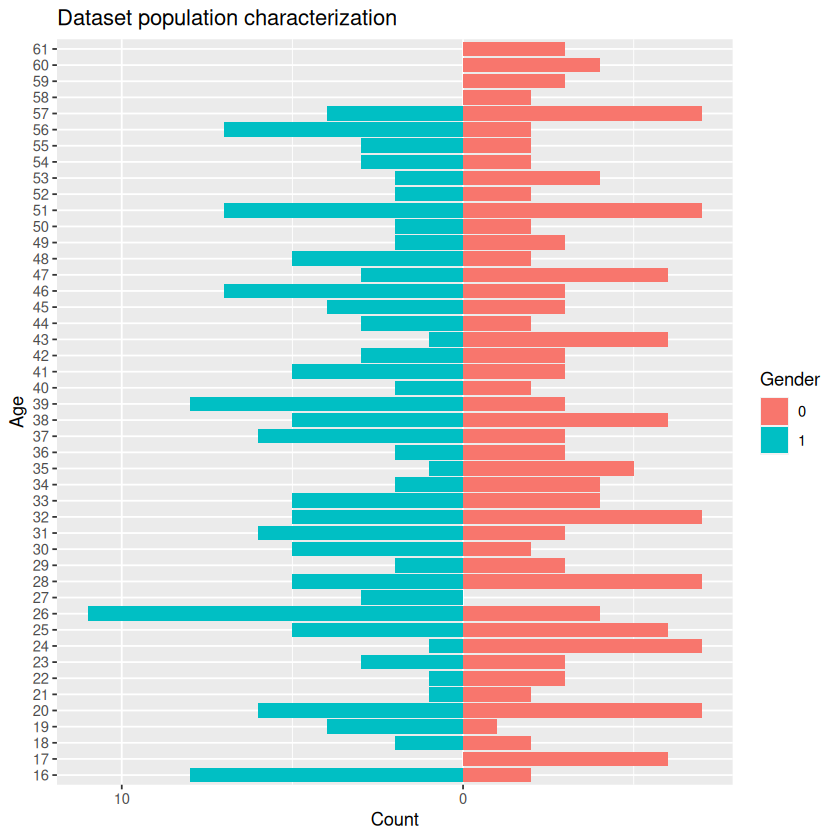

In [4]:
ggplot(data=data,aes(x=as.factor(client_age),fill=as.factor(gender))) + 
  geom_bar(data=subset(data,gender=="0")) + 
  geom_bar(data=subset(data,gender=="1"),aes(y=after_stat(count)*(-1))) + 
  scale_y_continuous(breaks=seq(-40,40,10),labels=abs(seq(-40,40,10))) + 
  labs(fill="Gender", x="Age", y="Count", title="Dataset population characterization") +
  coord_flip()

We can see that this dataset is composed of clients between the ages of 16 and 61, having about the same number of male and female.

Since the target variable is the "status", we will try to find how other variables can influence it's result.

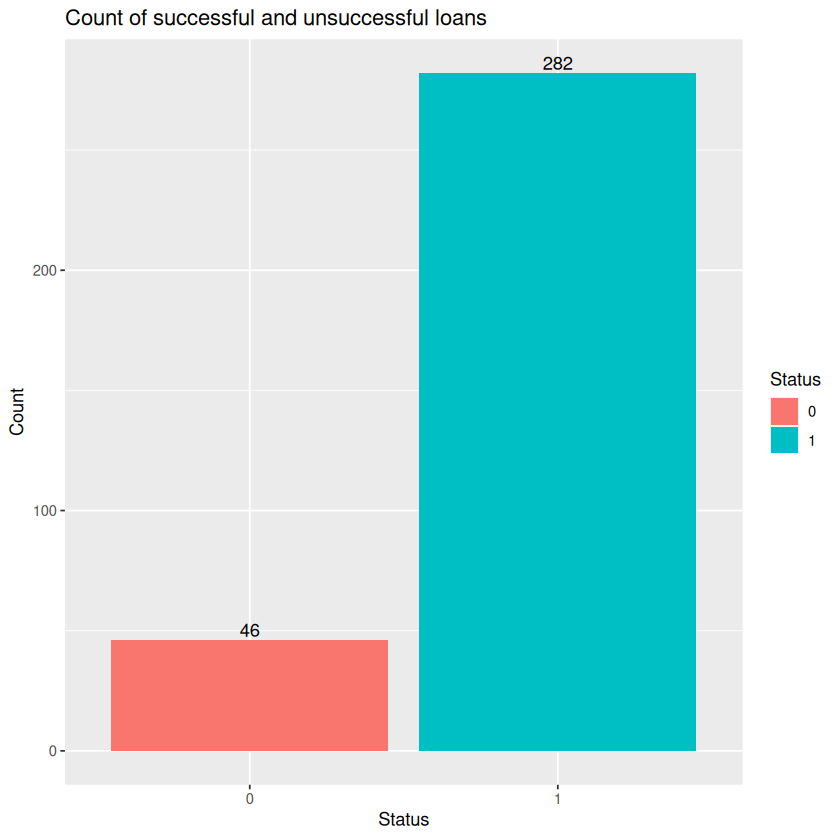

In [34]:
loan_frq <- data %>%
  count(status)

ggplot(loan_frq, aes(x=as.factor(status), y=n, fill=as.factor(status))) + 
  labs(fill="Status", x="Status", y="Count", title="Count of successful and unsuccessful loans") +
  geom_bar(stat = "identity") +
  geom_text(aes(label=n), position=position_dodge(width=0.9), vjust=-0.25)

This simple graph shows the number of successful (1) and unsuccessful (0) loans. We can now see that there is a very small number of unssuccessful loans when compared to successful. That is something we need to keep in mind for the next steps, as it makes the dataset unbalanced. Possible solutions are to replicate the unsuccessfull loans, reduce successfull loans or create unsuccessfull loans (SMOTE).


Now we can plot some data to try and find correlations between the loan status and other attributes. Let's start by plotting the correlation matrix.

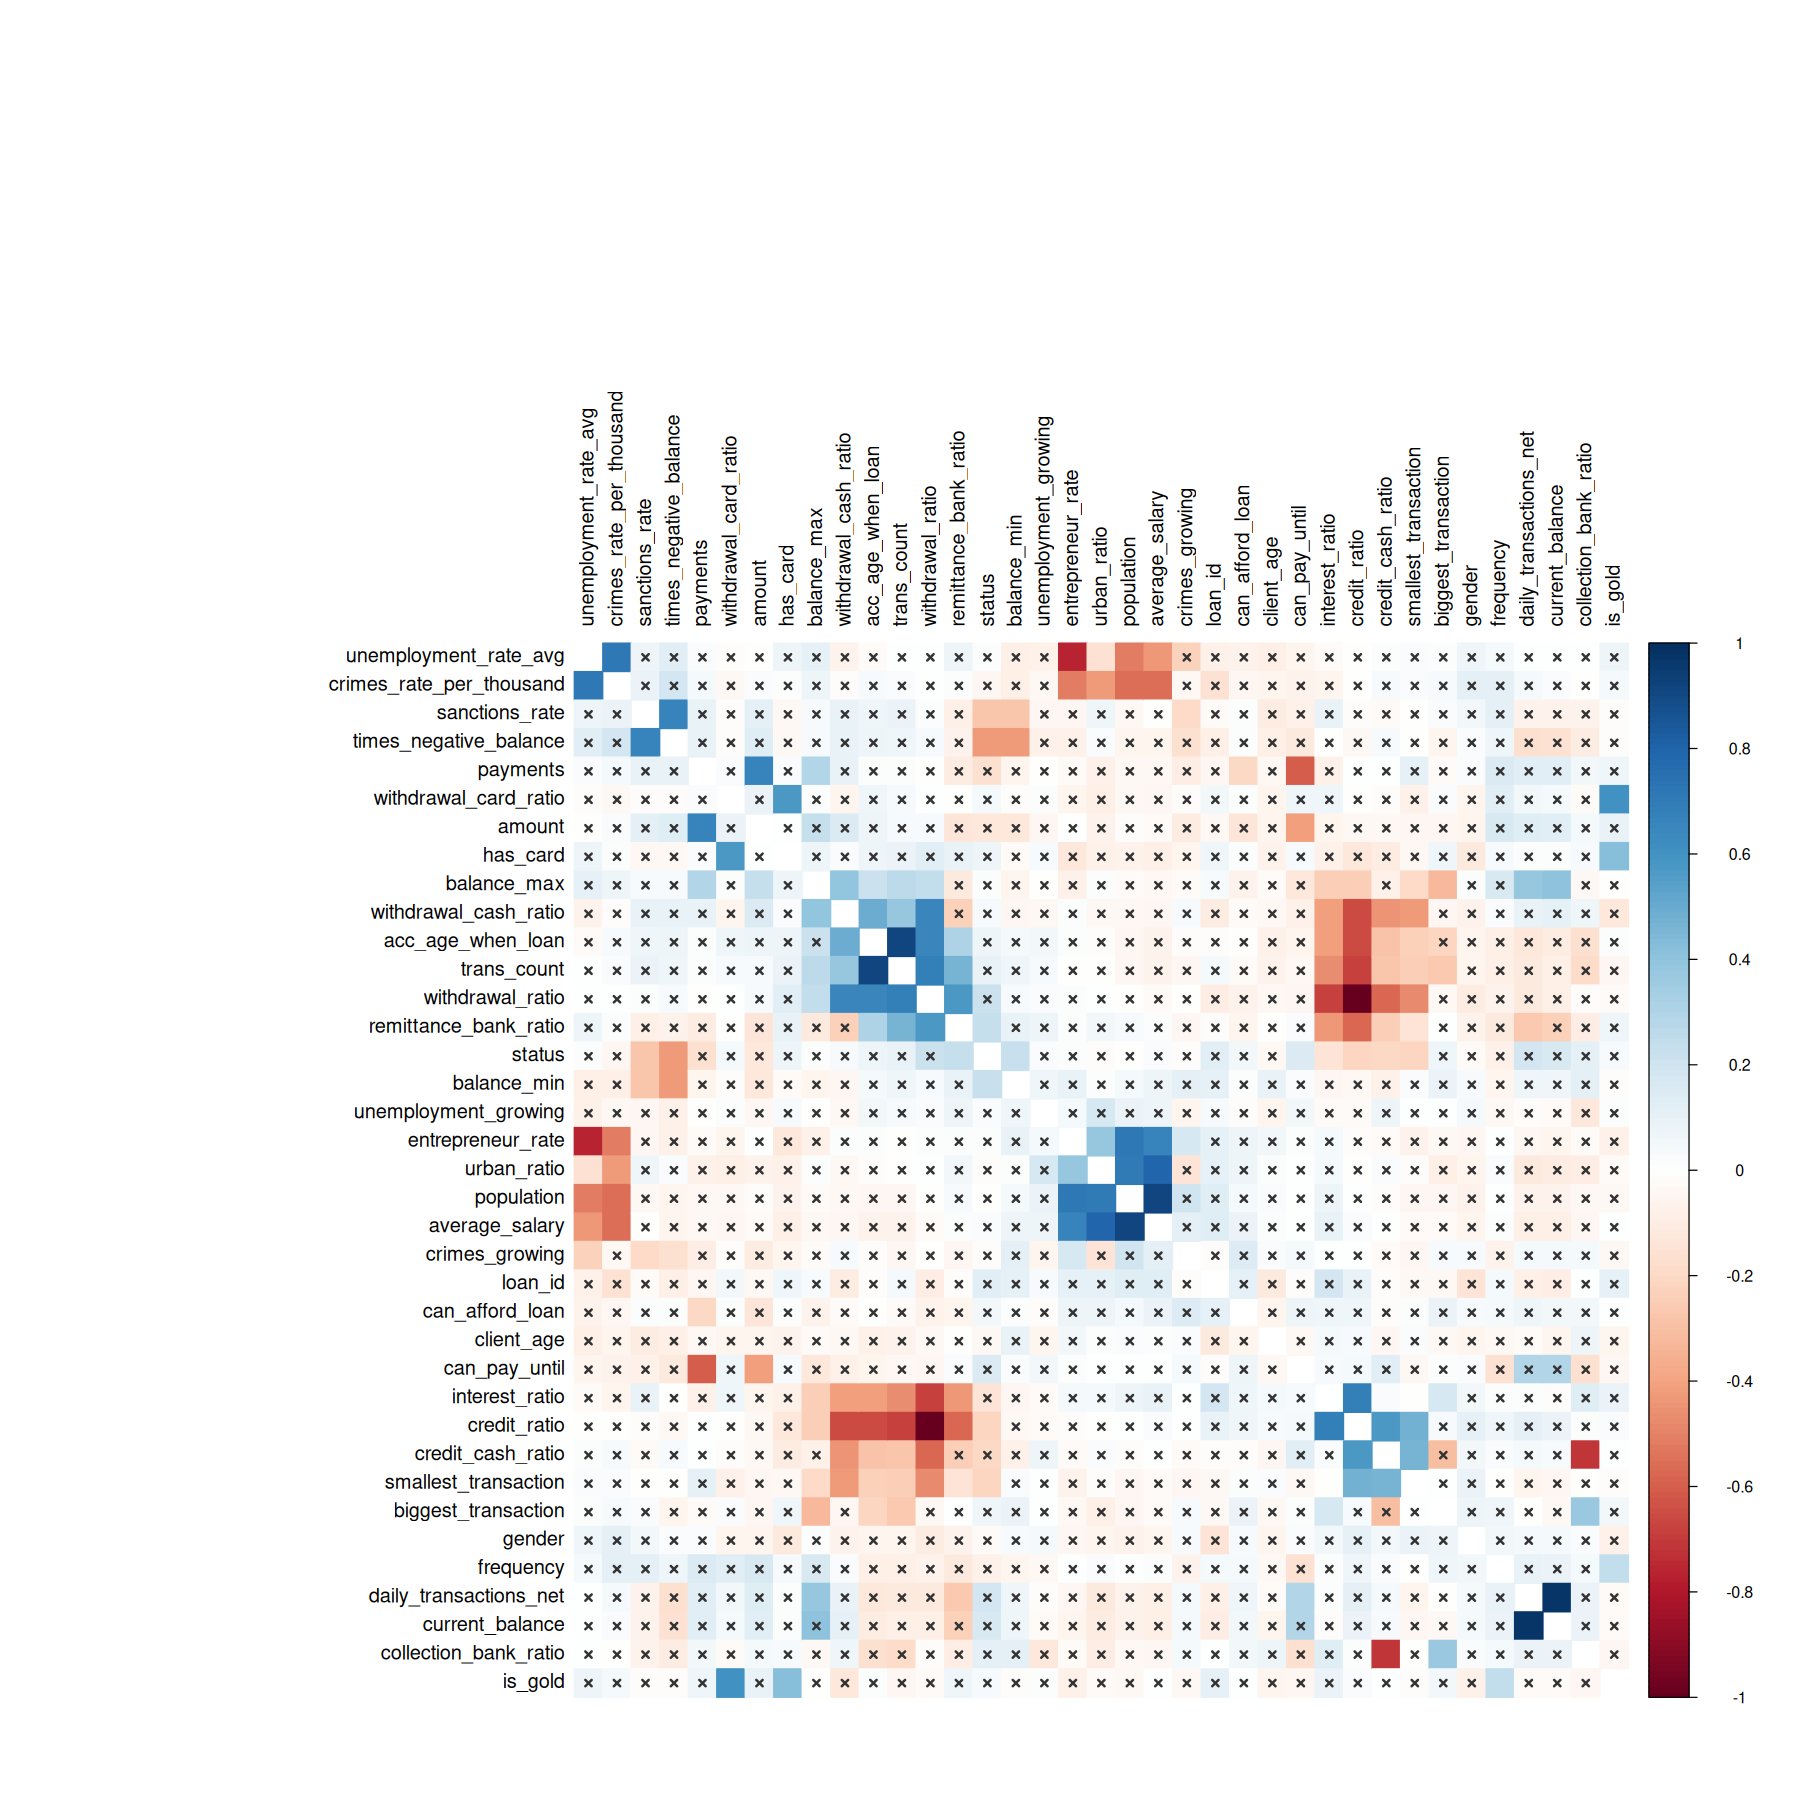

In [42]:
data_cor <- data %>%
    select_if(is.numeric) %>%
    cor(.)

testRes <- cor.mtest(data_cor, conf.level = 0.95)

options(repr.plot.width=15, repr.plot.height=15)
## add significant level stars
corrplot(data_cor, p.mat = testRes$p, method = 'color', diag = FALSE,
         sig.level = c(0.001, 0.01, 0.05), pch.cex = 0.7,
         insig = 'pch', pch.col = 'grey20', order = 'AOE', tl.col="black")
options(repr.plot.width=7, repr.plot.height=7)

In this matrix, the insignificant correlations are marked with an "x", so we won't consider those for now.
Let's look at what attributes seem to be more directly correlated with our target variable, the status, and how:
- **sanctions_rate**: High sanctions rate seem to be correlated with **unsuccessful** loans;
- **times_negative_balance**: Having an account that has had negative balace more times seems to be correlated with **unsuccessful** loans;
- **remittance_bank_ratio**: Having an account that has had more "remittance to another bank" operations seems to be correlated with **successful** loans;
- **balance_min**: Higher lowest balance on the account seems to be correlated with **successful** loans; 
- **can_pay_until**: Having money to cover the payments for a longer duration seems to be associated with **successful** loans; 
- **interest_ratio**: Having an account that has had more "interest credited" operations seems to be correlated with **unsuccessful** loans;
- **credit_ratio**: Having an account that has had more "credit card withdrawal" operations seems to be correlated with **unsuccessful** loans;
- **credit_cash_ratio**: Having an account that has had more "credit in cash" operations seems to be correlated with **unsuccessful** loans;
- **smallest_transaction**: Having had a higher amount for the smallest_transactions (no small transactions made) seems to be correlated to **unsuccessful** loans.

We can test some of these by plotting graphs showing how these variables influence the loan success, and try to find other relations between the data.

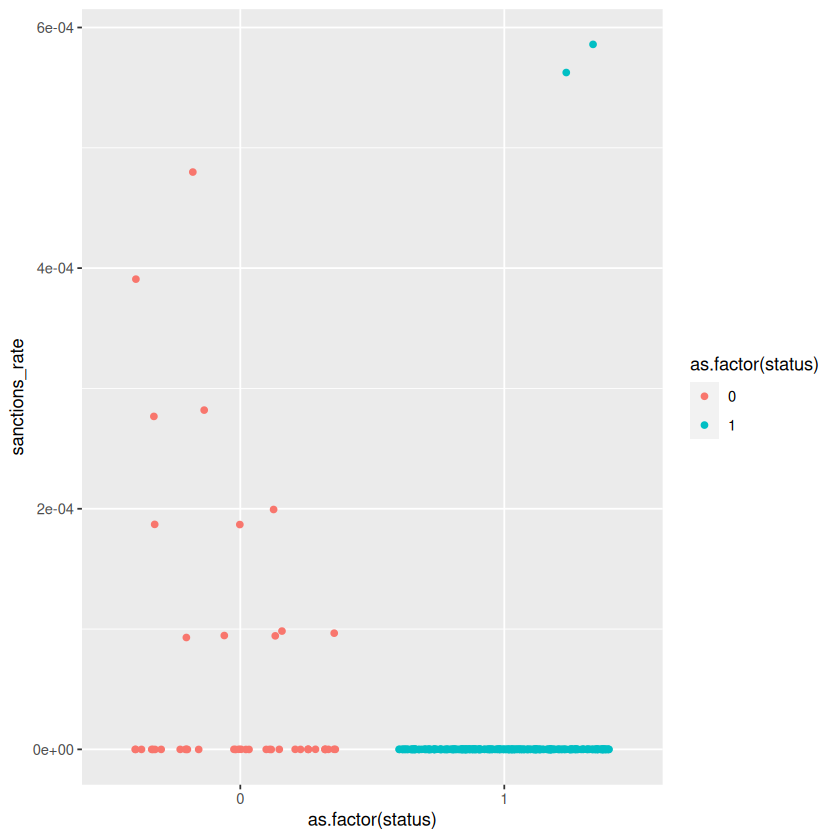

In [61]:
ggplot(data, aes(x=as.factor(status), y=sanctions_rate, color=as.factor(status))) +
geom_jitter()

From the small number of accounts that have been sanctioned in the past (14 dots), we can see that only a minority (2 dots) had a successful loan.

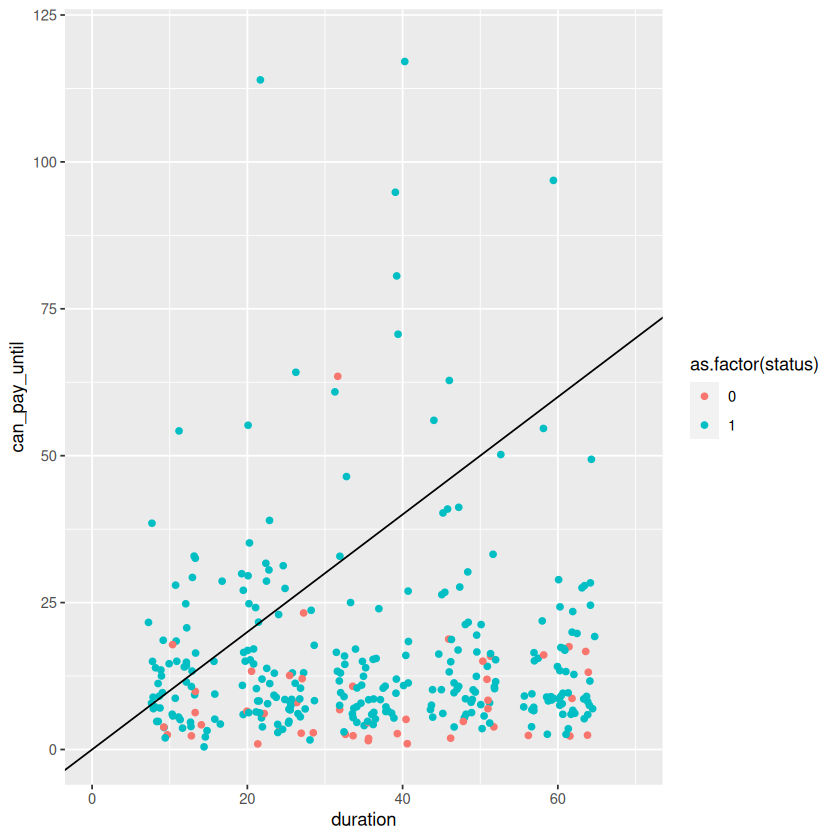

In [90]:
duration <- data$amount/data$payments

ggplot(data, aes(x=duration, y=can_pay_until, color=as.factor(status))) +
geom_jitter() +
ylim(0,120) +
xlim(0,70) +
geom_abline(slope=1, intercept = 0)

The can_pay_until attribute is derived from average_salary / payments, which means that it is the estimated time an average person from the district where the loan was asked will take to pay the loan back. In the plot above, we have plotted those variables and an y = x line, to better see which are the loans where the can_pay_until was lower than the duration, that is, which are the loans that an average person in those conditions could not pay back in time (represented by the dots under the line). 

Extracting conclusions from this graph alone could be tricky, as there are way less points above the line than below. But we can see that out of the unsuccessful loans, most of them happen under the line. That is, most of the unsuccessful loans where made by accounts that cou